In [6]:
import operator
import warnings
from typing import *
import traceback

import os
import sys

# Disable progress bars to avoid ipywidgets errors in VS Code
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["TQDM_DISABLE"] = "1"

import torch
from dotenv import load_dotenv
from IPython.display import Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()  # Suppress transformers warnings
import matplotlib.pyplot as plt
import numpy as np
import re

# Setup directory paths - must be before medrax imports
ROOT = "/home/ninad-nobo/ML_PROJECT"
sys.path.insert(0, ROOT)  # Add project root to Python path

from medrax.agent import *
from medrax.tools import *
from medrax.utils import *

import json
import openai
import glob
import time
import logging
from datetime import datetime
from tenacity import retry, wait_exponential, stop_after_attempt

warnings.filterwarnings("ignore")
_ = load_dotenv()


# Setup remaining directory paths
PROMPT_FILE = f"{ROOT}/medrax/docs/system_prompts.txt"
METADATA_FILE = f"{ROOT}/chestagentbench/metadata.jsonl"  # Use metadata.jsonl
MODEL_DIR = f"{ROOT}/model-weights"
FIGURES_DIR = f"{ROOT}/chestagentbench/figures"

model_name = "medrax"
temperature = 0.2
medrax_logs = f"{ROOT}/experiments/medrax_logs"
os.makedirs(medrax_logs, exist_ok=True)  # Create logs directory if it doesn't exist
log_filename = f"{medrax_logs}/{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
logging.basicConfig(filename=log_filename, level=logging.INFO, format="%(message)s", force=True)

# Detect CUDA availability
if torch.cuda.is_available():
    device = "cuda"
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("WARNING: No CUDA GPU available, using CPU. This will be slow!")
    print("Note: Some tools (like LlavaMedTool with load_in_8bit=True) may not work on CPU.")

Note: Some tools (like LlavaMedTool with load_in_8bit=True) may not work on CPU.


In [7]:
def get_tools():
    """Load tools, skipping any that fail to initialize (e.g., gated models).
    
    Available models in model-weights/:
    - IAMJB/chexpert-mimic-cxr-findings-baseline (for ChestXRayReportGeneratorTool)
    - IAMJB/chexpert-mimic-cxr-impression-baseline (for ChestXRayReportGeneratorTool)
    - StanfordAIMI/CheXagent-2-3b (for XRayVQATool)
    
    Gated/Missing models (skipped):
    - microsoft/maira-2 (XRayPhraseGroundingTool) - GATED
    - microsoft/llava-med-v1.5-mistral-7b (LlavaMedTool) - downloading
    """
    # Disable 8-bit loading on CPU (not supported)
    use_8bit = device == "cuda"
    
    tools = []
    
    # Tool 1: Report Generator (uses downloaded IAMJB models)
    try:
        report_tool = ChestXRayReportGeneratorTool(cache_dir=MODEL_DIR, device=device)
        tools.append(report_tool)
        print("✓ ChestXRayReportGeneratorTool loaded")
    except Exception as e:
        print(f"✗ ChestXRayReportGeneratorTool failed: {type(e).__name__}: {e}")
    
    # Tool 2: Classification (uses torchxrayvision - auto downloads)
    try:
        xray_classification_tool = ChestXRayClassifierTool(device=device)
        tools.append(xray_classification_tool)
        print("✓ ChestXRayClassifierTool loaded")
    except Exception as e:
        print(f"✗ ChestXRayClassifierTool failed: {type(e).__name__}: {e}")
    
    # Tool 3: Segmentation (uses torchxrayvision - auto downloads)
    try:
        segmentation_tool = ChestXRaySegmentationTool(device=device)
        tools.append(segmentation_tool)
        print("✓ ChestXRaySegmentationTool loaded")
    except Exception as e:
        print(f"✗ ChestXRaySegmentationTool failed: {type(e).__name__}: {e}")
    
    # Tool 4: XRay VQA (uses downloaded StanfordAIMI/CheXagent-2-3b)
    try:
        xray_vqa_tool = XRayVQATool(cache_dir=MODEL_DIR, device=device)
        tools.append(xray_vqa_tool)
        print("✓ XRayVQATool loaded")
    except Exception as e:
        print(f"✗ XRayVQATool failed: {type(e).__name__}: {e}")
    
    # Tool 5: Phrase Grounding - SKIPPED (microsoft/maira-2 is gated)
    print("⊘ XRayPhraseGroundingTool skipped (microsoft/maira-2 is gated)")
    
    # Tool 6: LLaVA-Med - SKIPPED (model is downloading, enable when complete)
    # Once download completes, uncomment below:
    # try:
    #     llava_med_tool = LlavaMedTool(
    #         model_path=f"{MODEL_DIR}/llava-med",  # Use local path
    #         cache_dir=MODEL_DIR, device=device, load_in_8bit=use_8bit
    #     )
    #     tools.append(llava_med_tool)
    #     print("✓ LlavaMedTool loaded")
    # except Exception as e:
    #     print(f"✗ LlavaMedTool failed: {type(e).__name__}: {e}")
    print("⊘ LlavaMedTool skipped (model downloading, enable when complete)")
    
    print(f"\nLoaded {len(tools)} tools successfully")
    if len(tools) == 0:
        raise RuntimeError("No tools could be loaded! Check your environment and model access.")
    
    return tools


def get_agent(tools):
    prompts = load_prompts_from_file(PROMPT_FILE)
    prompt = prompts["MEDICAL_ASSISTANT"]

    checkpointer = MemorySaver()
    model = ChatOpenAI(model="gpt-4o", temperature=temperature, top_p=0.95)
    agent = Agent(
        model,
        tools=tools,
        log_tools=True,
        log_dir="logs",
        system_prompt=prompt,
        checkpointer=checkpointer,
    )
    thread = {"configurable": {"thread_id": "1"}}
    return agent, thread


def run_medrax(agent, thread, prompt, image_urls=[]):
    messages = [
        HumanMessage(
            content=[
                {"type": "text", "text": prompt},
            ]
            + [{"type": "image_url", "image_url": {"url": image_url}} for image_url in image_urls]
        )
    ]

    final_response = None
    for event in agent.workflow.stream({"messages": messages}, thread):
        for v in event.values():
            final_response = v

    final_response = final_response["messages"][-1].content.strip()
    agent_state = agent.workflow.get_state(thread)

    return final_response, str(agent_state)

In [8]:
def load_metadata():
    """Load all questions from metadata.jsonl"""
    questions = []
    with open(METADATA_FILE, 'r') as f:
        for line in f:
            questions.append(json.loads(line.strip()))
    return questions


def process_question(question_data, agent, thread):
    """Process a single question from metadata.jsonl"""
    case_id = question_data["case_id"]
    question_id = question_data["question_id"]
    
    # Get image URLs directly from metadata
    image_urls = question_data.get("image_source_urls", [])
    
    # Build image path info for the prompt
    figure_prompt = ""
    for img_path in question_data.get("images", []):
        full_path = os.path.join(FIGURES_DIR, img_path.replace("figures/", ""))
        figure_prompt += f"{img_path} located at {full_path}\n"
    
    prompt = (
        f"Answer this question correctly using chain of thought reasoning and "
        "carefully evaluating choices. Solve using your own vision and reasoning and then "
        "use tools to complement your reasoning. Trust your own judgement over any tools.\n"
        f"{question_data['question']}\n{figure_prompt}"
    )

    try:
        start_time = time.time()

        final_response, agent_state = run_medrax(
            agent=agent, thread=thread, prompt=prompt, image_urls=image_urls
        )
        model_answer, agent_state = run_medrax(
            agent=agent,
            thread=thread,
            prompt="If you had to choose the best option, only respond with the letter of choice (only one of A, B, C, D, E, F)",
        )
        duration = time.time() - start_time

        # Extract answer letter
        model_answer = model_answer.strip().upper()
        if model_answer and model_answer[0] in "ABCDEF":
            model_answer = model_answer[0]
        
        correct_answer = question_data["answer"][0] if isinstance(question_data["answer"], str) else question_data["answer"]
        is_correct = model_answer == correct_answer

        log_entry = {
            "case_id": case_id,
            "question_id": question_id,
            "timestamp": datetime.now().isoformat(),
            "model": model_name,
            "temperature": temperature,
            "duration": round(duration, 2),
            "raw_response": final_response,
            "model_answer": model_answer,
            "correct_answer": correct_answer,
            "is_correct": is_correct,
            "categories": question_data.get("categories", ""),
            "input": {
                "question": question_data["question"],
                "explanation": question_data.get("explanation", ""),
                "images": question_data.get("images", []),
            },
        }
        logging.info(json.dumps(log_entry))
        return final_response, model_answer, correct_answer, is_correct, question_data.get("categories", "")

    except Exception as e:
        log_entry = {
            "case_id": case_id,
            "question_id": question_id,
            "timestamp": datetime.now().isoformat(),
            "model": model_name,
            "status": "error",
            "error": str(e),
        }
        logging.info(json.dumps(log_entry))
        print(f"Error processing case {case_id}, question {question_id}: {str(e)}")
        return "", "", question_data.get("answer", ""), False, ""


def main(tools, max_questions=None):
    """Run benchmark on ChestAgentBench using metadata.jsonl"""
    questions = load_metadata()
    total_questions = len(questions)
    
    if max_questions:
        questions = questions[:max_questions]
        print(f"Running on {max_questions} questions (out of {total_questions})")
    else:
        print(f"Running on all {total_questions} questions")
    
    print(f"\nBeginning benchmark evaluation for model {model_name} with temperature {temperature}\n")
    
    # Track results by category
    results = {
        "total": {"correct": 0, "total": 0},
        "detection": {"correct": 0, "total": 0},
        "classification": {"correct": 0, "total": 0},
        "localization": {"correct": 0, "total": 0},
        "comparison": {"correct": 0, "total": 0},
        "relationship": {"correct": 0, "total": 0},
        "diagnosis": {"correct": 0, "total": 0},
        "characterization": {"correct": 0, "total": 0},
        "reasoning": {"correct": 0, "total": 0},
    }
    
    agent, thread = get_agent(tools)
    
    for i, question_data in enumerate(questions):
        print(f"\n{'='*60}")
        print(f"Question {i+1}/{len(questions)}")
        
        final_response, model_answer, correct_answer, is_correct, categories = process_question(
            question_data, agent, thread
        )
        
        # Update totals
        results["total"]["total"] += 1
        if is_correct:
            results["total"]["correct"] += 1
        
        # Update category-specific results
        if categories:
            for cat in categories.split(","):
                cat = cat.strip().lower()
                if cat in results:
                    results[cat]["total"] += 1
                    if is_correct:
                        results[cat]["correct"] += 1
        
        # Print progress
        print(f"Case ID: {question_data['case_id']}")
        print(f"Question ID: {question_data['question_id']}")
        print(f"Categories: {categories}")
        print(f"Model Answer: {model_answer}")
        print(f"Correct Answer: {correct_answer}")
        print(f"Result: {'✓ CORRECT' if is_correct else '✗ WRONG'}")
        
        # Print running accuracy
        running_acc = results['total']['correct'] / results['total']['total'] * 100
        print(f"Running Accuracy: {running_acc:.1f}%")
    
    # Print final results
    print("\n" + "="*60)
    print("FINAL RESULTS - ChestAgentBench")
    print("="*60)
    print(f"\n{'Category':<20} {'Correct':<10} {'Total':<10} {'Accuracy':<10}")
    print("-"*50)
    
    for category, data in results.items():
        if data["total"] > 0:
            acc = data["correct"] / data["total"] * 100
            print(f"{category:<20} {data['correct']:<10} {data['total']:<10} {acc:.1f}%")
    
    return results

In [9]:
tools = get_tools()
# Run on first 10 questions for testing, remove max_questions to run all 2500
results = main(tools, max_questions=10)

✓ ChestXRayReportGeneratorTool loaded
✓ ChestXRayClassifierTool loaded
✓ ChestXRayClassifierTool loaded
✓ ChestXRaySegmentationTool loaded
✓ ChestXRaySegmentationTool loaded
✓ XRayVQATool loaded
⊘ XRayPhraseGroundingTool skipped (microsoft/maira-2 is gated)
⊘ LlavaMedTool skipped (model downloading, enable when complete)

Loaded 4 tools successfully
Running on 10 questions (out of 2500)

Beginning benchmark evaluation for model medrax with temperature 0.2

✓ XRayVQATool loaded
⊘ XRayPhraseGroundingTool skipped (microsoft/maira-2 is gated)
⊘ LlavaMedTool skipped (model downloading, enable when complete)

Loaded 4 tools successfully
Running on 10 questions (out of 2500)

Beginning benchmark evaluation for model medrax with temperature 0.2

✅ Conflict resolution enabled (sensitivity=0.4, deferral=0.6)

Question 1/10
✅ Conflict resolution enabled (sensitivity=0.4, deferral=0.6)

Question 1/10
Error processing case 11583, question 11583_8353800736258: Error code: 400 - {'error': {'code': 'B

In [10]:
# Save results to JSON and create comparison table
import pandas as pd
from datetime import datetime

# Save raw results
results_file = f"{medrax_logs}/results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to: {results_file}")

# Create DataFrame for comparison with paper's Table 1
categories = ['Detection', 'Classification', 'Localization', 'Comparison', 
              'Relationship', 'Diagnosis', 'Characterization', 'Overall']

# Paper's reported results (Table 1)
paper_results = {
    'LLaVA-Med': [32.4, 30.8, 30.2, 30.6, 31.8, 29.3, 28.8, 28.7],
    'CheXagent': [38.7, 34.7, 42.5, 38.5, 39.8, 33.5, 34.2, 39.5],
    'Llama-3.2-90B': [58.1, 56.5, 59.9, 57.5, 59.3, 55.9, 58.0, 57.9],
    'GPT-4o': [58.7, 54.6, 59.0, 55.5, 59.0, 52.6, 56.1, 56.4],
    'MedRAX (paper)': [64.1, 62.9, 63.6, 61.8, 63.1, 62.5, 64.0, 63.1],
}

# Your results
our_results = []
for cat in ['detection', 'classification', 'localization', 'comparison', 
            'relationship', 'diagnosis', 'characterization', 'total']:
    if results[cat]['total'] > 0:
        acc = results[cat]['correct'] / results[cat]['total'] * 100
        our_results.append(round(acc, 1))
    else:
        our_results.append(0.0)

paper_results['MedRAX (ours)'] = our_results

# Create comparison table
df = pd.DataFrame(paper_results, index=categories)
print("\n" + "="*80)
print("TABLE 1: Model Performance on ChestAgentBench - Accuracy (%)")
print("="*80)
print(df.to_string())

# Save as CSV
csv_file = f"{medrax_logs}/table1_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(csv_file)
print(f"\nComparison table saved to: {csv_file}")

Results saved to: /home/ninad-nobo/ML_PROJECT/experiments/medrax_logs/results_20260120_003002.json

TABLE 1: Model Performance on ChestAgentBench - Accuracy (%)
                  LLaVA-Med  CheXagent  Llama-3.2-90B  GPT-4o  MedRAX (paper)  MedRAX (ours)
Detection              32.4       38.7           58.1    58.7            64.1            0.0
Classification         30.8       34.7           56.5    54.6            62.9            0.0
Localization           30.2       42.5           59.9    59.0            63.6            0.0
Comparison             30.6       38.5           57.5    55.5            61.8            0.0
Relationship           31.8       39.8           59.3    59.0            63.1            0.0
Diagnosis              29.3       33.5           55.9    52.6            62.5            0.0
Characterization       28.8       34.2           58.0    56.1            64.0            0.0
Overall                28.7       39.5           57.9    56.4            63.1            0.0

C

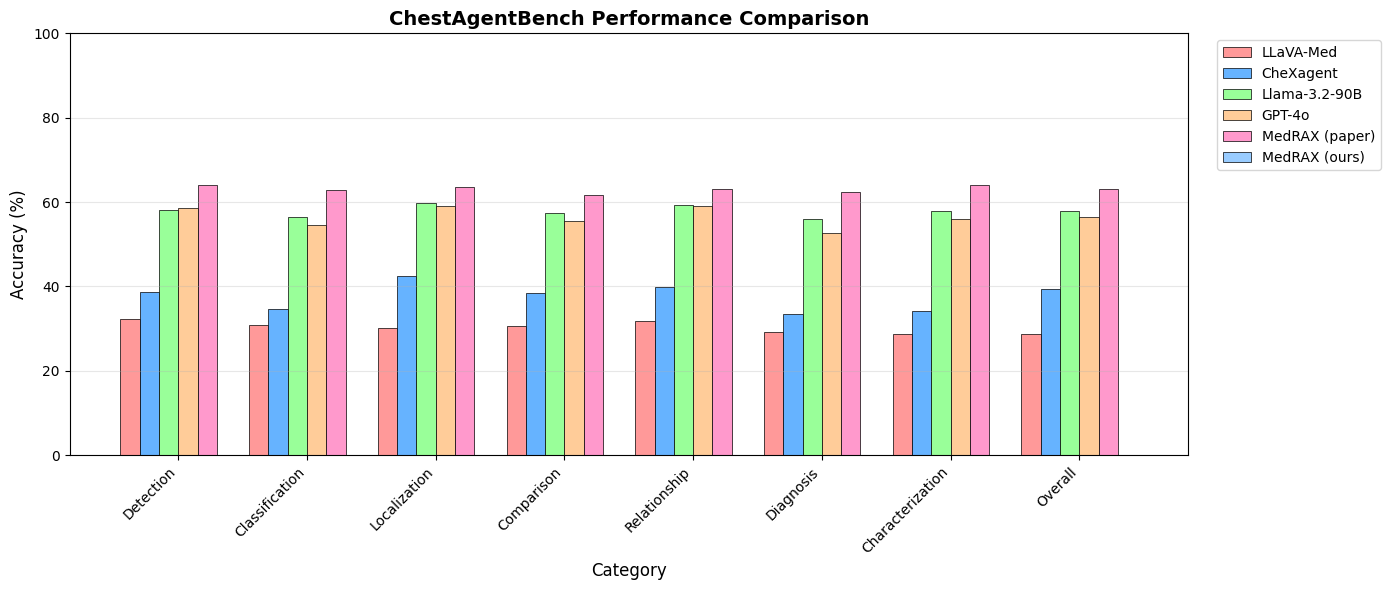


Chart saved to: /home/ninad-nobo/ML_PROJECT/experiments/medrax_logs/table1_comparison_chart.png


In [11]:
# Visualize results - Bar chart comparison
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
categories_plot = ['Detection', 'Classification', 'Localization', 'Comparison', 
                   'Relationship', 'Diagnosis', 'Characterization', 'Overall']

x = np.arange(len(categories_plot))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 6))

# Plot each model
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#99ccff']
models = ['LLaVA-Med', 'CheXagent', 'Llama-3.2-90B', 'GPT-4o', 'MedRAX (paper)', 'MedRAX (ours)']

for i, (model, color) in enumerate(zip(models, colors)):
    values = paper_results[model]
    bars = ax.bar(x + i*width, values, width, label=model, color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('ChestAgentBench Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(categories_plot, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{medrax_logs}/table1_comparison_chart.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\nChart saved to: {medrax_logs}/table1_comparison_chart.png")